In [ ]:
!pip install transformers datasets kagglehub torchinfo scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [ ]:
import torch
from torchinfo import summary
from datasets import load_dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DistilBertTokenizerFast, DistilBertConfig, DistilBertModel

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# 데이터셋 다운로드
import kagglehub

file_path = "debasisdotcom/name-entity-recognition-ner-dataset"

path = kagglehub.dataset_download(file_path)
print("file path", path)

file path /kaggle/input/name-entity-recognition-ner-dataset


In [ ]:
import pandas as pd

In [ ]:
# 데이터 확인하기

# UnicodeDecodeError로 encoding 지정해줌 : ISO-8859-1, latin1 등
df = pd.read_csv(path + '/NER dataset.csv', keep_default_na=False, encoding='ISO-8859-1')
# head : 첫 5행 / columns : column 명 배열과 데이터 타입
print("columns", df.columns)
df.head()

columns Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,,of,IN,O
2,,demonstrators,NNS,O
3,,have,VBP,O
4,,marched,VBN,O


### kaggle NER dataset 설명
* Sentence : 주어진 문장
* Word : 그 문장 속의 단어
* POS : Part of Speech Tag - 각 단어의 품사 (명사/동사/형용사/부사 등)
* Tag : Standard NER tags

In [ ]:
# Tag에 대해 더 알아보기

df['Prefix'] = df['Tag'].apply(lambda x: x.split('-')[0] if '-' in x else x)
print(df['Prefix'].value_counts())

Prefix
O    887908
B    111891
I     48776
Name: count, dtype: int64


### BIO Tagging (Begin, Inside, Outside)
* B-XXX : 문장 내에서 XXX type의 NER tag 중 가장 먼저 나온 것
* I-XXX : 문장 내에서 XXX type의 NER tag 중 두 번째부터 ~ 나머지
* O : NER tag에 속하지 않는 모든 단어  
dataset을 보면 O가 가장 많음  
그 다음으로는 특정 type에서 한 번만 나와도 B로 tagginge될 것이기 때문에 B가 많고 I 순

In [ ]:
df['Prefix'] = df['POS'].apply(lambda x: x.splt('-')[0] if '-' in x else x)
print(df['Prefix'].value_counts())

Prefix
NN      145807
NNP     131426
IN      120996
DT       98454
JJ       78412
NNS      75840
.        47831
VBD      39379
,        32757
VBN      32328
VBZ      24960
CD       24695
VB       24211
CC       23716
TO       23061
RB       20252
VBG      19125
VBP      16158
PRP      13318
POS      11257
PRP$      8655
MD        6973
``        3728
WDT       3698
JJS       3034
JJR       2967
WP        2542
NNPS      2521
RP        2490
WRB       2184
$         1149
RBR       1055
:          795
RRB        679
LRB        678
EX         663
RBS        296
;          214
PDT        147
WP$         99
UH          24
FW           1
Name: count, dtype: int64


## POS tag : 단어의 품사
* NN (Noun) : 명사  /  VB (Verb) : 동사  /  JJ (Adjective) : 형용사  /  RB (Adverb) : 부사
* PRP (Pronoun) : 대명사  /  CC (Conjunction) : 접속사  /  IN (Preposition) : 전치사  /  UH (Interjection) : 감탄사
* 아무래도 명사 NN, 대명사 PRP, 전치사 IN이 주를 이룸

In [ ]:
# data labeling 하기
# NER의 학습 목표가 어떤 entity인지 예측하는 것이기 때문에 Tag를 label로 삼기

# unique한 label만 선별
unique_tags = df['Tag'].unique().tolist()
print("unique_tags", unique_tags)
print()

# tag를 숫자로 mapping
tag2id = {tag: idx for idx, tag in enumerate(unique_tags)}
print("tag2id", tag2id)
print()

id2tag = {idx: tag for tag, idx in tag2id.items()}
print("id2tag", id2tag)
print()

unique_tags ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']

tag2id {'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8, 'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}

id2tag {0: 'O', 1: 'B-geo', 2: 'B-gpe', 3: 'B-per', 4: 'I-geo', 5: 'B-org', 6: 'I-org', 7: 'B-tim', 8: 'B-art', 9: 'I-art', 10: 'I-per', 11: 'I-gpe', 12: 'I-tim', 13: 'B-nat', 14: 'B-eve', 15: 'I-eve', 16: 'I-nat'}



In [ ]:
# 문장 단위로 group 만들기
from collections import defaultdict

def group_by_sentence(df, tag2id):
    grouped = defaultdict(lambda: {"tokens": [], "labels": []})

    for _, row in df.iterrows():
        sentence_id = row['Sentence #']
        word = row['Word']
        tag = row['Tag']

        grouped[sentence_id]['tokens'].append(word)
        grouped[sentence_id]['labels'].append(tag2id[tag])

    return list(grouped.values())

ner_data = group_by_sentence(df, tag2id)

# 예시
print("문장 수", len(ner_data))
print("첫 문장", ner_data[0])

문장 수 47960
첫 문장 {'tokens': ['Thousands'], 'labels': [0]}


In [ ]:
def tokenize_and_align_labels(tokenizer, tokens, labels, max_len=128):
    # tokenizer는 is_split_into_words=True 옵션 필요
    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors="pt"
    )

    # 토큰마다 어떤 단어에서 온건지
    word_ids = encoding.word_ids(batch_index=0)

    aligned_labels = []
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100)
        elif word_idx != previous_word_idx:
            aligned_labels.append(labels[word_idx])
        else:
            aligned_labels.append(-100)
        previous_word_idx = word_idx

    encoding['labels'] = torch.tensor(aligned_labels)
    return encoding

# 예시
example = ner_data[0]
encoded = tokenize_and_align_labels(tokenizer, example['tokens'], example['labels'])

print(encoded['input_ids'].shape)
print(encoded['labels'])

torch.Size([1, 128])
tensor([-100,    0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100])


* -100을 넣는 이유
  label은 단어 단위로 있는데, 단어를 잘게 나누면 한 개의 단어가 2개의 토큰으로 보일 수 있음
  이때, 첫 번째 토큰을 제외한 나머지 토큰에 -100을 부여

In [ ]:
from torch.utils.data import Dataset

# NER dataset 정의
class NERDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        tokens = item['tokens']
        labels = item['labels']

        encoded = tokenize_and_align_labels(
            self.tokenizer, tokens, labels, max_len=self.max_len
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'labels': encoded['labels']
        }

In [ ]:
from sklearn.model_selection import train_test_split

# train, test split
train_data, test_data = train_test_split(ner_data, test_size=0.1, random_state=42)

train_dataset = NERDataset(train_data, tokenizer, tag2id)
test_dataset = NERDataset(test_data, tokenizer, tag2id)

In [ ]:
from torch.utils.data import DataLoader

# data loader 구성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
from transformers import DistilBertConfig, DistilBertForTokenClassification

# 모델 생성 함수
def get_ner_model(pretrained, num_labels):
    if pretrained:
        return DistilBertForTokenClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=num_labels
        )
    else:
        config = DistilBertConfig(num_labels=num_labels)
        return DistilBertForTokenClassification(config)

In [ ]:
from torch.optim import Adam

def train_model(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    return total_loss

In [ ]:
# 정확도 측정 함수
def accuracy(model, dataloader, device):
    model.eval()
    total_tokens, correct_tokens = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = outputs.logits.argmax(dim=-1)

            # loss 계산에서 제외한 토큰(-100)은 평가에서도 제외
            mask = labels != -100
            total_tokens += mask.sum().item()
            correct_tokens += ((predictions == labels) & mask).sum().item()

    return correct_tokens / total_tokens

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(losses, train_accs, test_accs, title='Training Metrics'):
    epochs = list(range(1, len(losses) + 1))

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o', color='tab:red', label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, marker='o', color='tab:blue', label='Train Accuracy')
    plt.plot(epochs, test_accs, marker='x', color='tab:green', label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

    plt.suptitle(f"{title}", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
def run_experiment(pretrained=True, lr=5e-5, epochs=5, weight_decay=0.01, device=device):
    print(f"\n▶ Running {'[Pretrained]' if pretrained else '[Untrained]'} model "
          f"for {epochs} epochs | lr={lr}, weight_decay={weight_decay}")

    # 모델 구성
    model = get_ner_model(pretrained, num_labels=len(tag2id)).to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(1, epochs + 1):
        train_loss = train_model(model, train_loader, optimizer, device)
        train_acc = accuracy(model, train_loader, device)
        test_acc = accuracy(model, test_loader, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch:2d} | Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    plot_metrics(train_losses, train_accs, test_accs, title=f"{'Pretrained' if pretrained else 'Untrained'} | lr={lr} | Epochs={epochs}")

    return {
        'model': model,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    }


▶ Running [Pretrained] model for 5 epochs | lr=5e-05, weight_decay=0.01


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch  1 | Loss: 762.4290 | Train Acc: 0.9336 | Test Acc: 0.9306
Epoch  2 | Loss: 639.1539 | Train Acc: 0.9396 | Test Acc: 0.9266
Epoch  3 | Loss: 589.2826 | Train Acc: 0.9457 | Test Acc: 0.9310
Epoch  4 | Loss: 577.3082 | Train Acc: 0.9451 | Test Acc: 0.9320
Epoch  5 | Loss: 555.4128 | Train Acc: 0.9461 | Test Acc: 0.9327


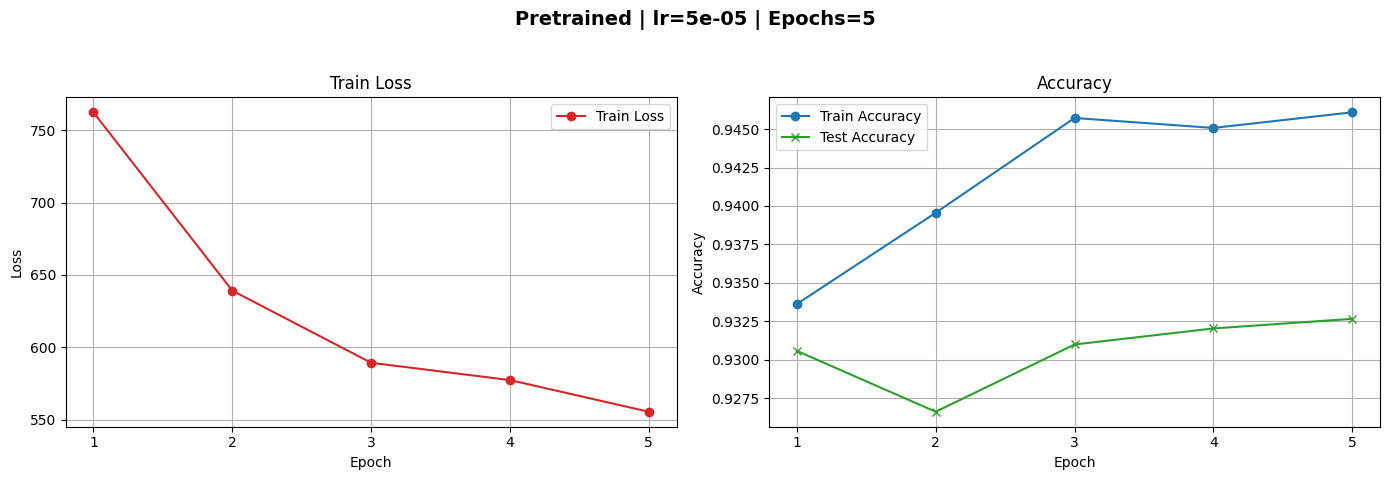


▶ Running [Untrained] model for 5 epochs | lr=5e-05, weight_decay=0.01
Epoch  1 | Loss: 967.1012 | Train Acc: 0.9339 | Test Acc: 0.9256
Epoch  2 | Loss: 627.4614 | Train Acc: 0.9456 | Test Acc: 0.9337
Epoch  3 | Loss: 567.2658 | Train Acc: 0.9435 | Test Acc: 0.9333
Epoch  4 | Loss: 547.0005 | Train Acc: 0.9469 | Test Acc: 0.9337
Epoch  5 | Loss: 534.1267 | Train Acc: 0.9448 | Test Acc: 0.9333


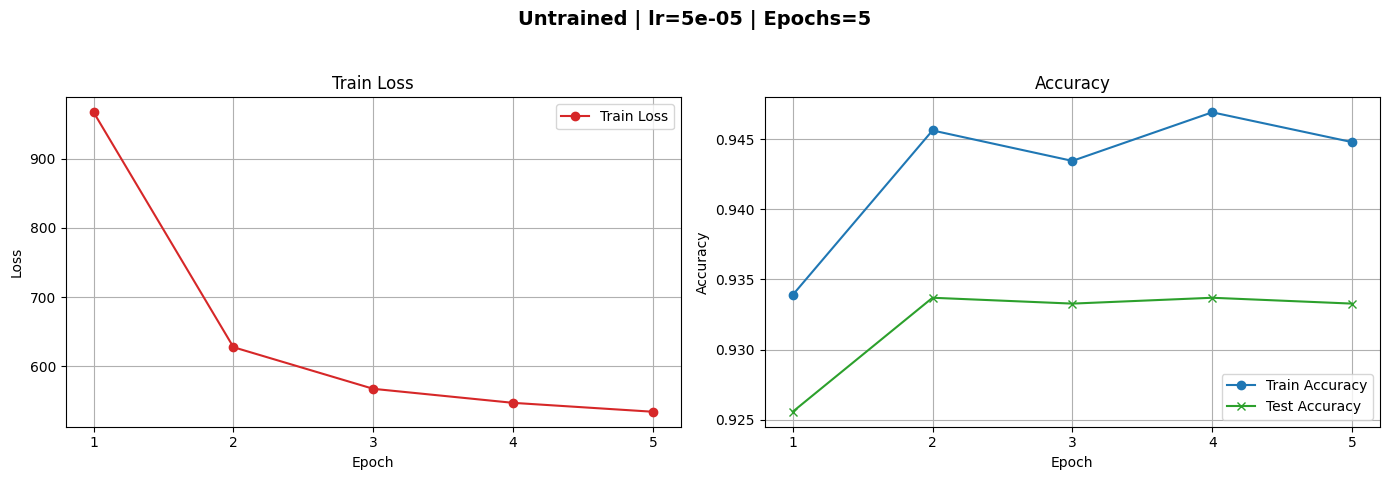

In [ ]:
result_pretrained = run_experiment(pretrained=True, lr=5e-5, epochs=5, device=device)
result_untrained = run_experiment(pretrained=False, lr=5e-5, epochs=5, device=device)